In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.10.0


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# %pip install seaborn
# %pip install nltk
# %pip install transformers

In [4]:
# 

In [5]:
# %pip install imblearn


In [14]:
import pandas as pd
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [15]:
# Load the datasets
true_news = pd.read_csv('./real_stances.csv')
fake_news = pd.read_csv('./fake_stances.csv')

# Add labels
true_news['label'] = 1 
fake_news['label'] = 0

print("True News Dataset Info:")
print(true_news.info())
print("Fake News Dataset Info:")
print(fake_news.info())

data = pd.read_csv('./merged1.csv')
print(data.info())


True News Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12587 entries, 0 to 12586
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  12587 non-null  object
 1   Body ID   12587 non-null  int64 
 2   label     12587 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 295.1+ KB
None
Fake News Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37385 entries, 0 to 37384
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  37385 non-null  object
 1   Body ID   37385 non-null  int64 
 2   label     37385 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 876.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headline     49972 non-null  object
 1   Body I

In [16]:
# Drop unnecessary columns
data = data.drop(['Body ID'], axis=1)

# Shuffle the data
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


In [17]:
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    return text

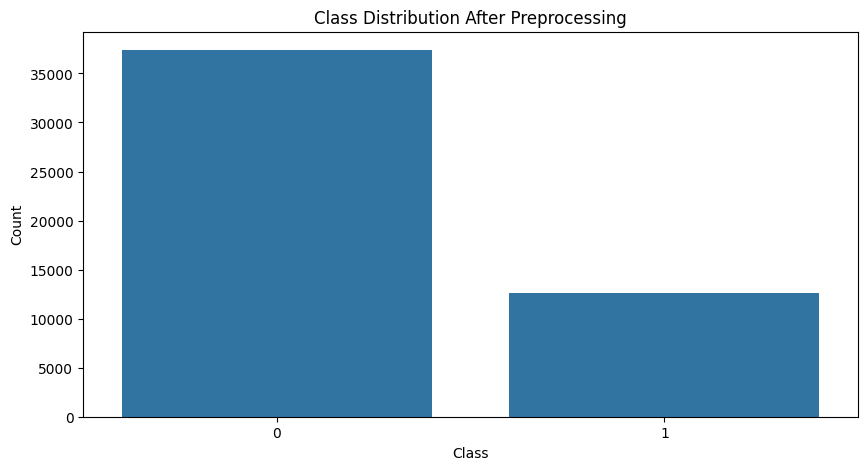

In [18]:
# Apply preprocessing to title and text
data['Headline'] = data['Headline'].apply(preprocess_text)
data['articleBody'] = data['articleBody'].apply(preprocess_text)

# Create 'combined_text'
data['combined_text'] = data['Headline'] + ' ' + data['articleBody']

# Visualize class distribution after preprocessing
plt.figure(figsize=(10, 5))
sns.countplot(x='label', data=data)
plt.title('Class Distribution After Preprocessing')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [19]:
# Tokenization settings
max_len = 500  # BERT max sequence length
bert_model_name = "bert-base-uncased"

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)



Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [20]:
# Define function to tokenize text for BERT
def encode_texts(texts, tokenizer, max_len):
    return tokenizer(
        texts.tolist(),  # List of texts to tokenize
        padding='max_length',  # Pad all sequences to max_len
        truncation=True,  # Truncate sequences longer than max_len
        max_length=max_len,  # Maximum length of sequences
        return_tensors='np',  # Return NumPy arrays
        return_attention_mask=True,  # Return attention masks
    )


In [21]:
# Assuming 'data' contains your dataset with columns 'combined_text' and 'label'
# Split the data into features (X) and labels (y)
X = data['combined_text']
y = data['label'].values

# Split into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [22]:

# Encode the training and testing text data using BERT tokenizer
X_train_encoded = encode_texts(X_train, tokenizer, max_len)
X_test_encoded = encode_texts(X_test, tokenizer, max_len)



In [23]:
# Extract 'input_ids' and 'attention_mask' from the encoded training data
input_ids_train = X_train_encoded['input_ids']
attention_mask_train = X_train_encoded['attention_mask']

# Reshape both 'input_ids' and 'attention_mask' to apply SMOTE on them together
train_features = np.hstack([input_ids_train, attention_mask_train])

# Apply SMOTE to resample both 'input_ids' and 'attention_mask' combined
smote = SMOTE(sampling_strategy='minority')
train_features_resampled, y_train_resampled = smote.fit_resample(train_features, y_train)

# After resampling, split the combined features back into 'input_ids' and 'attention_mask'
input_ids_resampled = train_features_resampled[:, :max_len]
attention_mask_resampled = train_features_resampled[:, max_len:]

# Now, define your BERT-based model architecture
# Define input layers
input_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
attention_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# Get BERT embeddings
bert_output = bert_model(input_ids, attention_mask=attention_mask)
pooled_output = bert_output.pooler_output  # [CLS] token representation

# Add dropout and a dense layer for binary classification
x = Dropout(0.5)(pooled_output)
output = Dense(1, activation='sigmoid')(x)

# Build and compile the model
model = Model(inputs=[input_ids, attention_mask], outputs=output)
model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 500)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 500)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 500,                                           

In [26]:
from tensorflow.keras.mixed_precision import set_global_policy

# Enable mixed precision for memory efficiency
set_global_policy('mixed_float16')

# Now train the model
model.fit(
    [input_ids_resampled, attention_mask_resampled],  # Training inputs
    y_train_resampled,  # Resampled labels
    validation_data=([X_test_encoded['input_ids'], X_test_encoded['attention_mask']], y_test),  # Test set
    epochs=5,  # Number of epochs
    batch_size=16  # Batch size
)


Epoch 1/5


ResourceExhaustedError: Graph execution error:

Detected at node 'model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/mul_1' defined at (most recent call last):
    File "C:\Users\k7adi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\k7adi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "e:\Project\FND_new\myenv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "e:\Project\FND_new\myenv\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\k7adi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\k7adi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\k7adi\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "e:\Project\FND_new\myenv\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "e:\Project\FND_new\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "e:\Project\FND_new\myenv\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "e:\Project\FND_new\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "e:\Project\FND_new\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "e:\Project\FND_new\myenv\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\k7adi\AppData\Local\Temp\ipykernel_12788\3298838929.py", line 7, in <module>
      model.fit(
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\modeling_tf_utils.py", line 1182, in run_call_with_unpacked_inputs
      dummies[key] = tf.zeros_like(dummies[key])
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 1209, in call
      outputs = self.bert(
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\modeling_tf_utils.py", line 1182, in run_call_with_unpacked_inputs
      dummies[key] = tf.zeros_like(dummies[key])
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 969, in call
      encoder_outputs = self.encoder(
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 603, in call
      for i, layer_module in enumerate(self.layer):
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 609, in call
      layer_outputs = layer_module(
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 548, in call
      intermediate_output = self.intermediate(hidden_states=attention_output)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "e:\Project\FND_new\myenv\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 432, in call
      hidden_states = self.intermediate_act_fn(hidden_states)
    File "e:\Project\FND_new\myenv\lib\site-packages\keras\activations.py", line 359, in gelu
      return tf.nn.gelu(x, approximate)
Node: 'model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/mul_1'
failed to allocate memory
	 [[{{node model/tf_bert_model/bert/encoder/layer_._0/intermediate/Gelu/mul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_25428]

In [ ]:
# from tensorflow.keras.mixed_precision import set_global_policy

# # Enable mixed precision for memory efficiency
# set_global_policy('mixed_float16')

# # Now train the model
# model.fit(
#     [input_ids_resampled, attention_mask_resampled],  # Training inputs
#     y_train_resampled,  # Resampled labels
#     validation_data=([X_test_encoded['input_ids'], X_test_encoded['attention_mask']], y_test),  # Test set
#     epochs=5,  # Number of epochs
#     batch_size=32  # Batch size
# )
